In [1]:
#%%
from pathlib import Path

import numpy as np
import snapatac2 as snap
from gcell._settings import get_setting

annotation_dir = get_setting('annotation_dir')
print("gcell currently using annotation directory:", annotation_dir)


gcell currently using annotation directory: /home/xf2217/.gcell_data/annotations


# Data Preparation Tutorial from SnapATAC2 / Cell Ranger

This tutorial demonstrates how to prepare single-cell multiome (RNA + ATAC) data for GET model training.

We'll use the PBMC10k dataset from 10x Genomics as an example.



## Overview:

1. Process RNA data - normalize, filter for highly variable genes

2. Process ATAC data - compute spectral embedding

3. Filter for abundant cell types

4. Generate peak accessibility and gene expression files for each cell type

## 0. Download cellranger-ARC processed data from 10x
```bash
wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5"
wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz"
wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz.tbi"
wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_peaks.bed"
wget "http://catlas.org/catlas_downloads/humantissues/cCRE_hg38.tsv.gz"
```

In [2]:
import pandas as pd
from pyranges import PyRanges as pr

cre = pd.read_csv('cCRE_hg38.tsv.gz', sep='\t')
cre = cre.rename(columns={'#Chromosome': 'Chromosome', 'hg38_Start': 'Start', 'hg38_End': 'End'})[['Chromosome', 'Start', 'End']]
cre = pr(cre, int64=True).sort()

In [3]:
import scanpy as sc

ad = sc.read_10x_h5('pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5', gex_only=False)
ad

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11898 × 180488
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

This hdf5 contains the count matrix for both gene expression and peak count.
We can have a look at the peaks called by cellranger.

In [10]:
summits = pd.read_csv('pbmc_summits.bed', sep='\t', header=None, names=['Chromosome', 'Start', 'End', 'Name', 'Score'])
summits['Start'] = summits['Start'].astype(int)-200
summits['End'] = summits['Start'].astype(int)+400
summits=pr(summits[['Chromosome', 'Start', 'End']], int64=True).sort()

> Note: For optimal zero-shot analysis, it is recommended to use a union set of peaks 
> from both the new dataset and the original training peak sets (i.e. the cre peaks 
> defined above) to minimize domain shift. However, in this tutorial we will simply 
> perform finetuning using the new peak set from the 10x PBMC multiome data.
> The union peak set can be constructed as below. After that you should re-count the peak count
> matrix using fragment file, and when write out cell-type specific peaks, ideally remove all non-accessible peaks in
> each cell types.

In [12]:

# peak / cre + cre 
# find all peaks that don't overlap with cre; -> non_overlap_peaks
non_overlap_peaks = summits.overlap(cre, invert=True)
# concat with cre and sort
total_peaks = pd.concat([non_overlap_peaks.df, cre.df], ignore_index=True)
total_peaks = pr(total_peaks, int64=True).sort()
# remove chromosome M, Y and those not start with chr
total_peaks = total_peaks.df.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')
total_peaks


,Chromosome,Start,End
30,chr1,9955,10355
31,chr1,29163,29563
32,chr1,79215,79615
33,chr1,102755,103155
34,chr1,115530,115930
...,...,...,...
1160226,chrX,156001554,156001954
1160227,chrX,156003817,156004217
1160228,chrX,156006466,156006866
1160229,chrX,156029231,156029631


In [18]:
# read fragment file with snapatac2
import snapatac2 as snap

data = snap.pp.import_fragments(
    'pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz',
    chrom_sizes=snap.genome.hg38,
    file="pbmc.h5ad",  # Optional
    sorted_by_barcode=False,
)


In [21]:
# write total_peaks to bed
total_peaks.to_csv('total_peaks.bed', sep='\t', index=False, header=False)

In [24]:
# count peaks
peak_data = snap.pp.make_peak_matrix(data, peak_file='total_peaks.bed')

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 19227 × 1160196
    obs: 'n_fragment', 'frac_dup', 'frac_mito'

In [26]:
peak_data

AnnData object with n_obs × n_vars = 19227 × 1160196
    obs: 'n_fragment', 'frac_dup', 'frac_mito'

## 1. Cell type assignment

- Load RNA data from processed PBMC10k dataset and borrow the labels. If you have your own cell type labels on the data, skip this step.

- Select top 3000 highly variable genes and perform UMAP to cross check with assigned labels.


In [44]:
# %%
# read rna data
if not Path('rna.h5ad').exists():
    rna = snap.read(snap.datasets.pbmc10k_multiome(modality='RNA'), backed=None)
    sc.pp.highly_variable_genes(rna, flavor='seurat_v3', n_top_genes=3000)
    rna_filtered = rna[:, rna.var.highly_variable]
    sc.pp.normalize_total(rna_filtered, target_sum=1e4)
    sc.pp.log1p(rna_filtered)
    snap.tl.spectral(rna_filtered, features=None)
    snap.tl.umap(rna_filtered)
    rna_filtered.write('rna.h5ad')
else:
    rna_filtered = sc.read('rna.h5ad')

Here, I'm going to use the cell type labels from preprocessed snapatac2 object.

In [45]:
ad = ad[ad.obs.index.isin(rna_filtered.obs.index.values)]

In [48]:
barcode_to_celltype = rna_filtered.obs.to_dict()['cell_type']
peak_data.obs['cell_type'] = peak_data.obs.index.map(barcode_to_celltype)
ad.obs['cell_type'] = ad.obs.index.map(barcode_to_celltype)


/tmp/ipykernel_133430/3584719171.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  peak_data.obs['cell_type'] = peak_data.obs.index.map(barcode_to_celltype)
/tmp/ipykernel_133430/3584719171.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['cell_type'] = ad.obs.index.map(barcode_to_celltype)
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [30]:
peak_data.obs.head()

,n_fragment,frac_dup,frac_mito,cell_type
AAACAGCCAAGGAATC-1,44055,0.430173,0.0,NaN
AAACAGCCAATCCCTT-1,17430,0.451921,0.0,CD4 TCM
AAACAGCCAATGCGCT-1,14893,0.407362,0.0,CD4 Naive
AAACAGCCACAAAGAC-1,246,0.004049,0.0,NaN
AAACAGCCACACTAAT-1,1079,0.441511,0.0,NaN


In [31]:
# drop barcode with no cell type
peak_data = peak_data[peak_data.obs.cell_type.notna()]
peak_data

View of AnnData object with n_obs × n_vars = 9631 × 1160196
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'cell_type'

In [49]:
ad_rna = ad[:, np.where(ad.var.feature_types == 'Gene Expression')[0]]
ad_rna.obs

,cell_type
AAACAGCCAATCCCTT-1,CD4 TCM
AAACAGCCAATGCGCT-1,CD4 Naive
AAACAGCCACCAACCG-1,CD8 Naive
AAACAGCCAGGATAAC-1,CD4 Naive
AAACAGCCAGTTTACG-1,CD4 TCM
...,...
TTTGTTGGTGACATGC-1,CD8 Naive
TTTGTTGGTGTTAAAC-1,CD8 Naive
TTTGTTGGTTAGGATT-1,NK
TTTGTTGGTTGGTTAG-1,CD4 TCM


It seems the cell types match well with the data. So now let's collect the ATAC object and look at library sizes of different cell types. Note that if you have a very densely sampled dataset, you can also perform metacell analysis and sample pseudobulk with a consistent library size.

In [33]:
ad_atac = peak_data
ad_atac

View of AnnData object with n_obs × n_vars = 9631 × 1160196
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'cell_type'

We filter for cell types with >100 cells and at least 3M library size.

The selected cell types will be used for training GET models.

In [34]:
# %%

cell_number = ad_atac.obs.groupby('cell_type', observed=False).size().to_dict()
print("The following cell types have more than 100 cells and library size > 3M, adding them to celltype_for_modeling")
celltype_for_modeling = []
for cell_type in cell_number:
    if cell_number[cell_type] > 100:
        celltype_for_modeling.append(cell_type)
        libsize = int(ad_atac[ad_atac.obs.cell_type == cell_type].X.sum())
        if libsize > 3000000:
            print(f"{cell_type} number of cells: {cell_number[cell_type]}, library size: {libsize}")

The following cell types have more than 100 cells and library size > 3M, adding them to celltype_for_modeling
CD14 Mono number of cells: 2554, library size: 41041559
CD16 Mono number of cells: 442, library size: 6647422
CD4 Naive number of cells: 1382, library size: 18945325
CD4 TCM number of cells: 1113, library size: 15813376
CD4 TEM number of cells: 286, library size: 4428458
CD8 Naive number of cells: 1354, library size: 19788755
CD8 TEM_1 number of cells: 322, library size: 4603012
CD8 TEM_2 number of cells: 315, library size: 4012385
Intermediate B number of cells: 300, library size: 5414070
Memory B number of cells: 298, library size: 4618795
NK number of cells: 403, library size: 5621185
cDC number of cells: 180, library size: 3968421


## 2. Export training data
For each abundant cell type, we'll generate:
1. Peak accessibility file (.atac.bed) containing:
   - Peak coordinates (chr, start, end)
   - Normalized accessibility scores (aCPM, $10^5$ scale factor)
2. Gene expression file (.rna.csv) containing:
   - Gene names
   - Normalized expression values (TPM, $10^6$ scale factor)


In [35]:
# This should be the same as the peaks variable defined above.
import pandas as pd
from pyranges import PyRanges as pr
def get_peak_from_snapatac(atac: snap.AnnData):
    """
    Get the peak names from the snapatac object.

    Args:
        atac: snapatac2 processed AnnData object

    Returns:
        peak_names: pandas DatasFrame with the peak names
    """
    peak_names = pd.DataFrame(atac.var.index.str.split('[:-]').tolist(), columns=['Chromosome', 'Start', 'End'])
    peak_names['Start'] = peak_names['Start'].astype(int)
    peak_names['End'] = peak_names['End'].astype(int)
    return peak_names

peaks = get_peak_from_snapatac(ad_atac)
peaks.shape

(1160196, 3)

In [36]:
# %%
def get_peak_acpm_for_cell_type(atac: snap.AnnData, cell_type: str):
    """
    Get the peak acpm for a given cell type.
    """
    peaks = get_peak_from_snapatac(atac)
    counts = np.array(atac[atac.obs.cell_type == cell_type].X.sum(0)).flatten()
    acpm = np.log10(counts / counts.sum() * 1e5 + 1)
    peaks['aCPM'] = acpm/acpm.max()
    peaks = peaks.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')
    peaks = pr(peaks, int64=True).sort().df
    return peaks

Let's run the function above to save the peak with aCPM for all cell types. Note that here we use the common peak set for all cell types. Later in the dataset we will be able to filter out peaks with no accessibility for each cell type.

In [37]:
# %%
import os
os.makedirs('preprocess_recall_peak/', exist_ok=True)
for cell_type in celltype_for_modeling:
    peaks = get_peak_acpm_for_cell_type(ad_atac, cell_type)
    peaks.to_csv(f'preprocess_recall_peak/{cell_type.replace(" ", "_").lower()}.atac.bed', sep='\t', index=False, header=False)

<Axes: xlabel='aCPM', ylabel='length'>

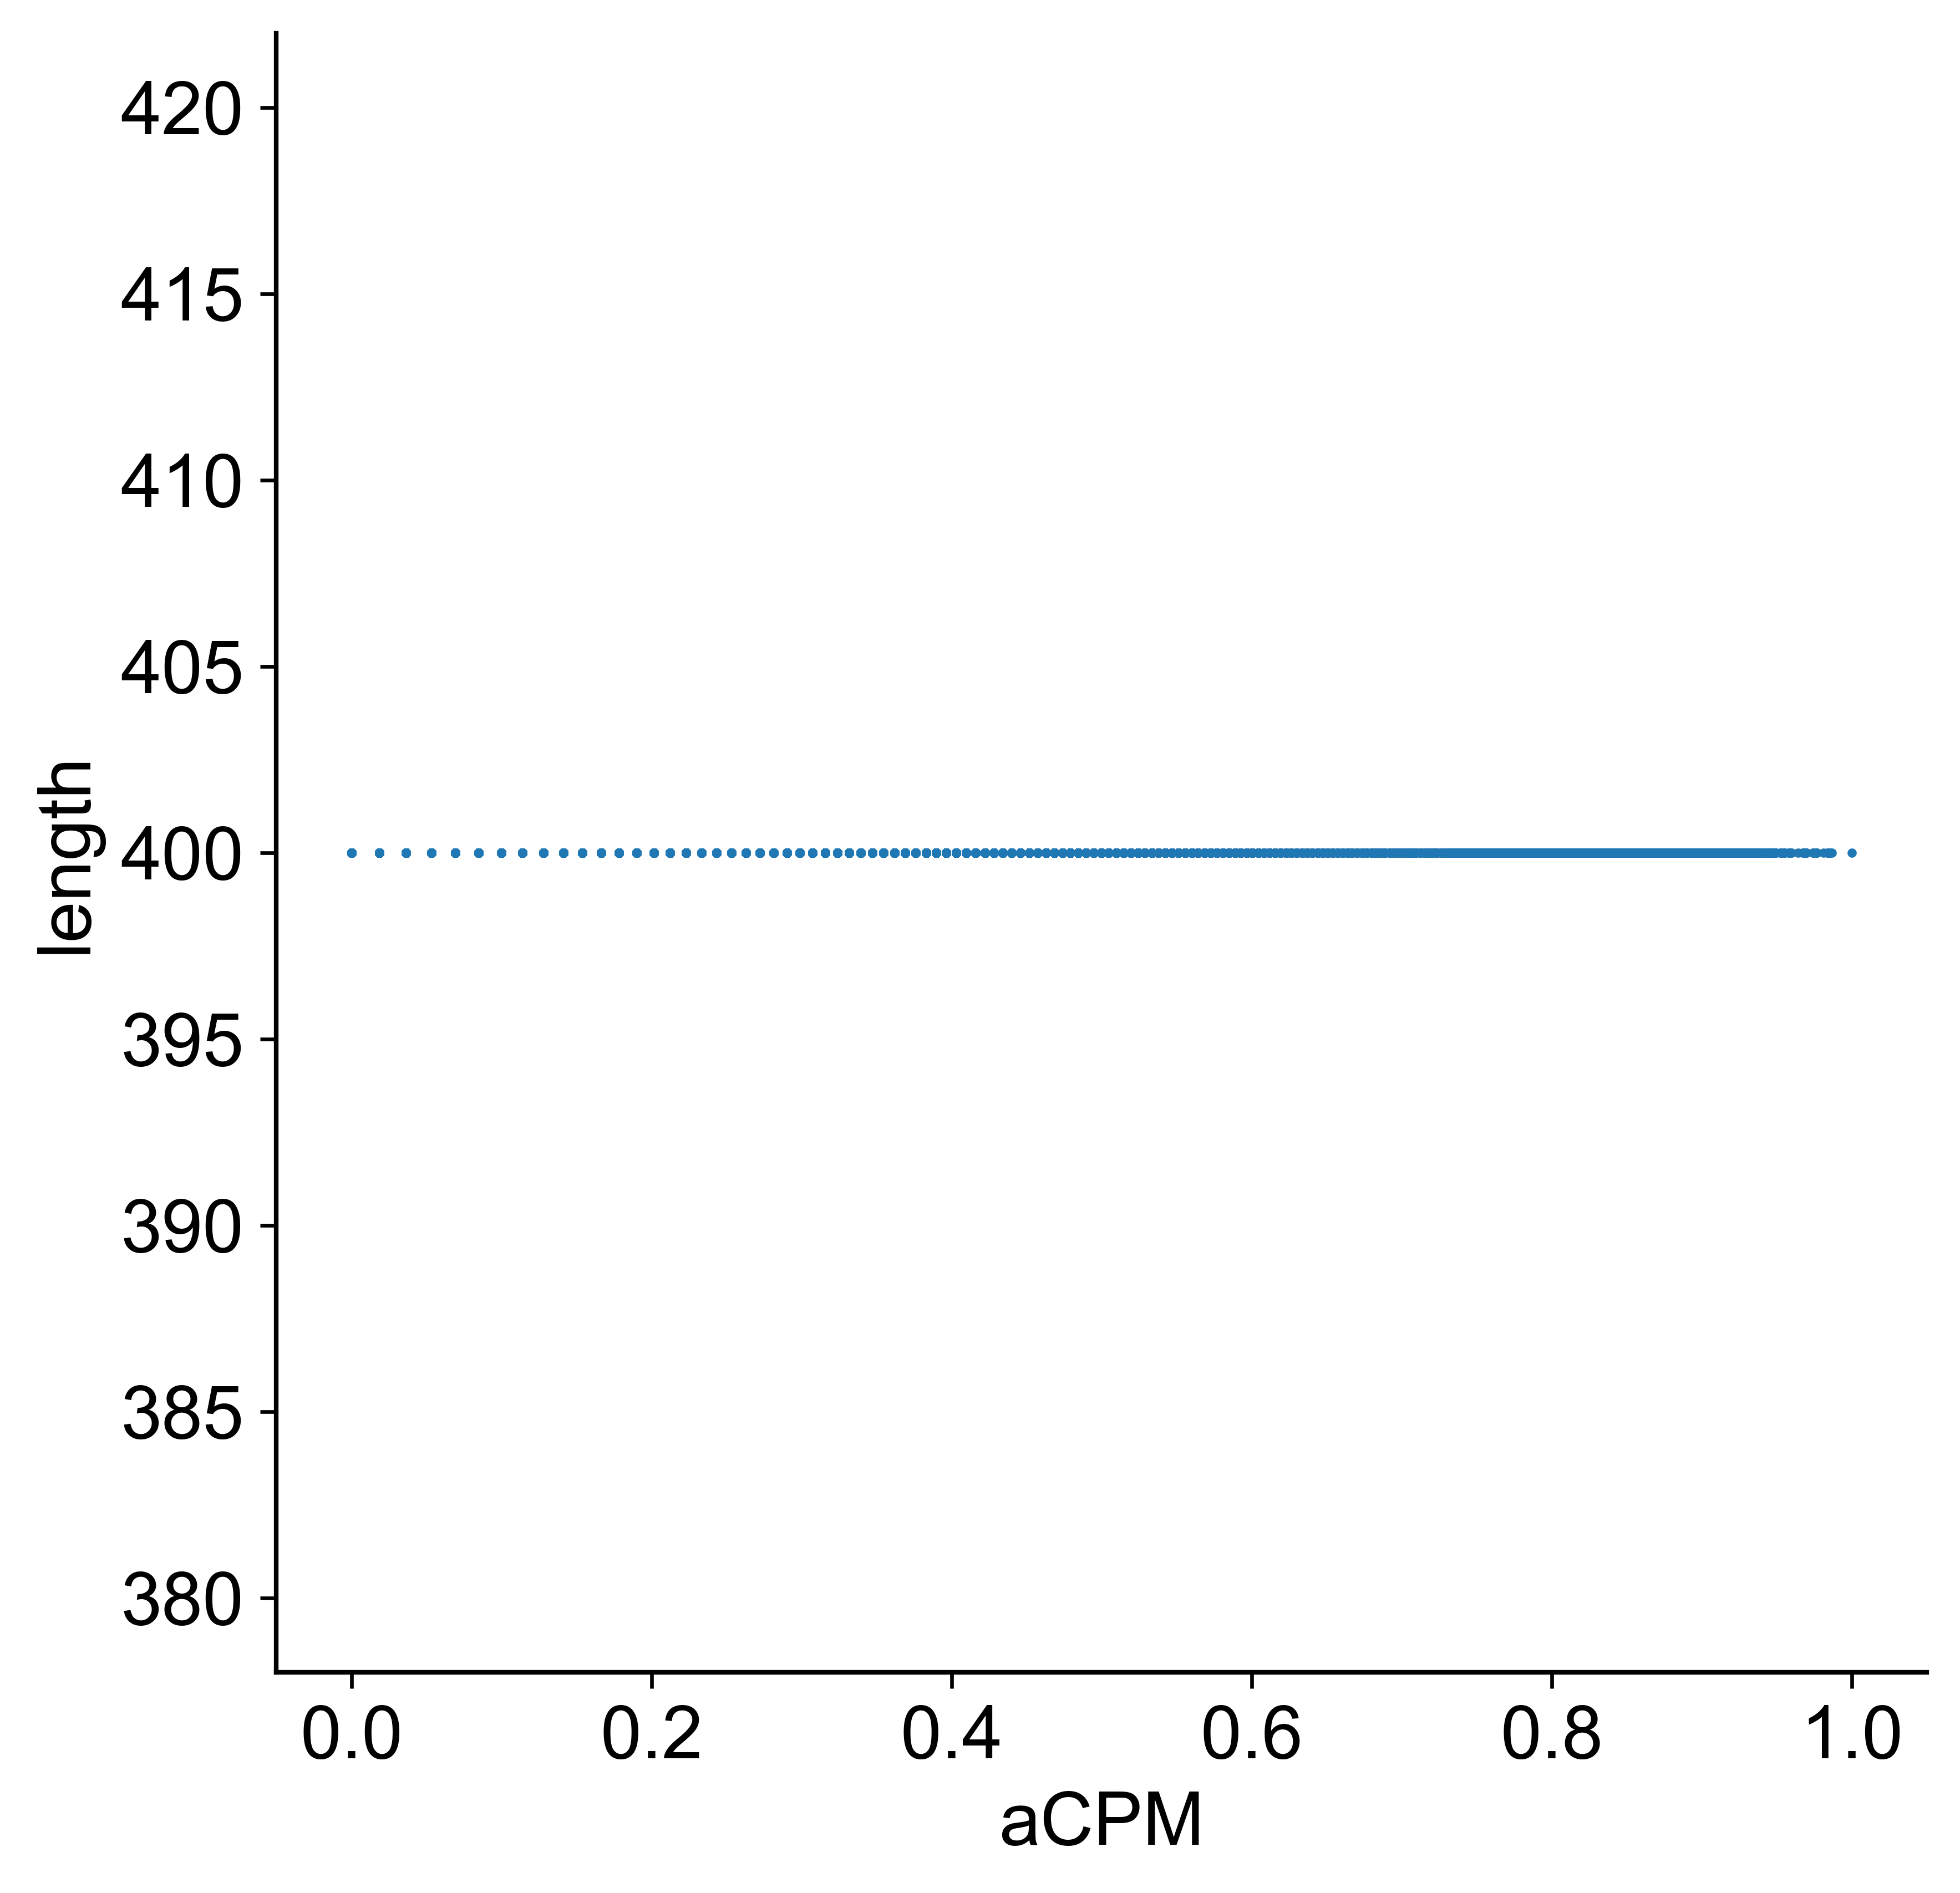

In [38]:
peaks['length'] = peaks['End'] - peaks['Start']
peaks.plot(y='length', x='aCPM', kind='scatter', s=1)

Now let's save the RNA csv files.

In [50]:
# %%
def get_rna_for_cell_type(rna: snap.AnnData, cell_type: str):
    """
    Get the rna for a given cell type.
    """
    counts = rna[rna.obs.cell_type == cell_type].X.sum(0)
    counts = np.log10(counts / counts.sum() * 1e6 + 1)
    counts = np.array(counts).flatten()
    rna_tpm = pd.DataFrame(counts, columns=['TPM'])
    rna_tpm['gene_name'] = rna.var.index
    return rna_tpm[['gene_name', 'TPM']].sort_values(by='gene_name', ascending=True)

In [51]:
ad_rna.obs

,cell_type
AAACAGCCAATCCCTT-1,CD4 TCM
AAACAGCCAATGCGCT-1,CD4 Naive
AAACAGCCACCAACCG-1,CD8 Naive
AAACAGCCAGGATAAC-1,CD4 Naive
AAACAGCCAGTTTACG-1,CD4 TCM
...,...
TTTGTTGGTGACATGC-1,CD8 Naive
TTTGTTGGTGTTAAAC-1,CD8 Naive
TTTGTTGGTTAGGATT-1,NK
TTTGTTGGTTGGTTAG-1,CD4 TCM


In [52]:
#%%
for cell_type in celltype_for_modeling:
    rna_tpm = get_rna_for_cell_type(ad_rna, cell_type)
    rna_tpm.to_csv(f'preprocess_recall_peak/{cell_type.replace(" ", "_").lower()}.rna.csv', index=False)

## 3. Query motifs and save data as zarr files.

In [53]:
# NOTE: tabix has to be >= 1.17
! tabix --version

tabix (htslib) 1.21
Copyright (C) 2024 Genome Research Ltd.


In [54]:
import os
from pathlib import Path

from gcell._settings import get_setting
from preprocess_utils import (
    add_atpm,
    add_exp,
    create_peak_motif,
    download_motif,
    get_motif,
    query_motif,
)

annotation_dir = Path(get_setting('annotation_dir'))
print("gcell currently using annotation directory:", annotation_dir)

gcell currently using annotation directory: /home/xf2217/.gcell_data/annotations


### Download motif bed file

This will download the non-redundant motif scanning results to `annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz"`.

In [55]:
motif_bed_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz"
motif_bed_index_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz.tbi"


if (
    motif_bed_url
    and motif_bed_index_url
    and not (
        (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz").exists()
        or (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz.tbi").exists()
    )
):
    download_motif(motif_bed_url, motif_bed_index_url, motif_dir=annotation_dir)
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")
else:
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")

### Query motif

In [56]:
peak_bed = "preprocess_recall_peak/cd4_naive.atac.bed" # since all cell types share the same peak set, when querying motifs, we can just use one cell type to query motifs.
peaks_motif = query_motif(peak_bed, motif_bed)
get_motif_output = get_motif(peak_bed, peaks_motif)


Peak motif extraction completed. Results saved in get_motif.bed


## 4. Create peak motif zarr file
Create a peak x motif matrix stored in a zarr file. If you are working on multiple cell types with the same peak set, you can use the same peak bed and zarr file for all cell types.

In [57]:
create_peak_motif(get_motif_output, "preprocess_recall_peak/pbmc10k_multiome.zarr", peak_bed) # all cell types will later be added to the same zarr file as we use the same peak set.


Peak motif data saved to preprocess_recall_peak/pbmc10k_multiome.zarr


### Add aCPM data to region x motif matrix
For each cell type, we will save it's aCPM values to the `pbmc10k_multiome.zarr/atpm/{celltype}/` folder

In [60]:

# CD14 Mono number of cells: 2554, library size: 41041559
# CD16 Mono number of cells: 442, library size: 6647422
# CD4 Naive number of cells: 1382, library size: 18945325
# CD4 TCM number of cells: 1113, library size: 15813376
# CD4 TEM number of cells: 286, library size: 4428458
# CD8 Naive number of cells: 1354, library size: 19788755
# CD8 TEM_1 number of cells: 322, library size: 4603012
# CD8 TEM_2 number of cells: 315, library size: 4012385
# Intermediate B number of cells: 300, library size: 5414070
# Memory B number of cells: 298, library size: 4618795
# NK number of cells: 403, library size: 5621185
# cDC number of cells: 180, library size: 3968421
celltype_for_modeling = [
    'cd14_mono',
    'cd16_mono',
    'cd4_naive',
    'cd4_tcm',
    'cd4_tem',
    'cd8_naive',
    'cd8_tem_1',
    'cd8_tem_2',
    'intermediate_b',
    'memory_b',
    'nk',
    'cdc',
    'gdt',
    'treg',
 ]

In [61]:
for cell_type in celltype_for_modeling:
    add_atpm(
        "preprocess_recall_peak/pbmc10k_multiome.zarr",
        f"preprocess_recall_peak/{cell_type}.atac.bed",
        cell_type,
    )

        Chromosome      Start        End      aTPM                      Name
0             chr1       9955      10355  0.012480           chr1:9955-10355
1             chr1      29163      29563  0.001495          chr1:29163-29563
2             chr1      79215      79615  0.000748          chr1:79215-79615
3             chr1     102755     103155  0.001495        chr1:102755-103155
4             chr1     115530     115930  0.002239        chr1:115530-115930
...            ...        ...        ...       ...                       ...
1160191       chrX  156001554  156001954  0.001495  chrX:156001554-156001954
1160192       chrX  156003817  156004217  0.001495  chrX:156003817-156004217
1160193       chrX  156006466  156006866  0.003723  chrX:156006466-156006866
1160194       chrX  156029231  156029631  0.000000  chrX:156029231-156029631
1160195       chrX  156030075  156030475  0.013198  chrX:156030075-156030475

[1160196 rows x 5 columns]
        Chromosome      Start        End      aT

### Add expression and TSS data to region x motif matrix

In [62]:
for cell_type in celltype_for_modeling:
    add_exp(
        "preprocess_recall_peak/pbmc10k_multiome.zarr",
        f"preprocess_recall_peak/{cell_type}.rna.csv",
        f"preprocess_recall_peak/{cell_type}.atac.bed",
        cell_type,
        assembly="hg38",
        version=44,
        extend_bp=300, # extend TSS region to 300bp upstream and downstream when overlapping with peaks
    id_or_name="gene_name", # use gene_name or gene_id to match the gene expression data, checkout your rna.csv file column names, should be either [gene_name, TPM] or [gene_id, TPM]
)

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
/home/xf2217/Projects/get_model.worktrees/refactor_with_hydra/tutorials/preprocess_utils.py:338: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["index", "Strand"])
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
/home/xf2217/Projects/get_model.worktrees/refactor_with_hydra/tutorials/preprocess_utils.py:338: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

### Clean up intermediate files

In [63]:
for file in [peaks_motif, get_motif_output]:
    os.remove(file)

This has conclude the data processing steps.